In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
from bokeh.models import HoverTool,ColumnDataSource

In [3]:
dt_qzvpp=pd.read_pickle('data_def2_qzvpp')
dt_tzvp=pd.read_pickle('data_def2_tzvp')
dt_sto3g=pd.read_pickle("data_sto3G")
dt_sto6g=pd.read_pickle("data_sto6G")
dt_321g=pd.read_pickle("data_321G")
dt_631g=pd.read_pickle("data_631G")
dt_aug=pd.read_pickle("data_aug")
dt_ccpvtz=pd.read_pickle("data_ccpvtz")

In [4]:
dfp=dt_qzvpp.query("alchemy==4").copy()
p = figure(title="Def2-QZVPP",plot_width=1800, plot_height=1000)
alcolor={0:'purple',1:'blue',2:'green',3:'black',4:'red'}
def alcol(ao):
    return alcolor[ao]
Alcol=[alcol(x) for x in list(dfp.alchemy)]
dfp['alcol']=Alcol
drdV=[]
#dfp['err_alch']=np.abs(dfp['err_alch'])
source = ColumnDataSource(dfp)
p.cross('delta_rho', 'err_alch', source=source,color='alcol')
#p.line(dfp.delta_rho)
hover = HoverTool()
hover.tooltips = [("Reference","@ref"), ("Target", "@target"),("Distance",'@distance'),\
                  ('Alchemy','@alchemy'),('Alchemy error','@err_alch'),('delta_Rho','@delta_rho')]#,('Total error','@tot_err')]
hover.mode = 'mouse'
p.add_tools(hover)
p.xaxis.axis_label = 'delta_Rho'
p.yaxis.axis_label = 'Alchemy error'
show(p)

In [5]:
proj_path="/home/giorgiod/MRCC_interface/PES-BS-ALCHEMY/"

In [6]:
def parse_energy(log_file,calc):
    calc_str={"hf":"FINAL HARTREE-FOCK ENERGY","ccsd" : "Total CCSD energy", "mp2":"Total MP2 energy [au]" }
    """Parse the hartree Fock energy from an MRCC output file"""
    try:
        with open(log_file,'r') as logf:
            while True:
                line=logf.readline()
                if calc_str[calc] in line:
                    good_line=line
                    for x in good_line.split(' '):
                        try:
                            float(x)
                            return (float(x))
                        except:
                            pass    
    except:
        print('couldn\'t parse energy return 0 for: '+log_file)
        return 0

In [7]:
def dirName(basis_set,molecule,point,alchemy=0):
    return proj_path+basis_set+'/'+molecule+"/A{}_Radius:{}".format(alchemy,str(point)[0:3])+'/'

In [8]:
def energy(bs,mol,pt,calc,al=0):
    return parse_energy(dirName(bs,mol,pt,al)+'run.log',calc)
basisSets=['sto3G', 'sto6G', '321G','631G*','def2-TZVP','def2-QZVPP','cc-pVTZ','aug-cc-pVQZ']
molecules=['HAl','HeMg','LiNa','BeNe','BF','CO','NN']

In [9]:
energy("sto3G","CO",2.4,"mp2")-energy("sto3G","CO",2.4,"ccsd")

-0.006897507429002303

In [10]:
dt_sto3g[:10]

,alchemy,distance,basis_set,e_alch,e_ccsd,ref,target,abs_err,delta_rho,e_at_ref_bs,err_alch
0,0,1.3,sto3G,-195.799703,-198.025411,HAl,HeMg,2.225708,3.368281,-196.696725,0.897022
1,1,1.3,sto3G,-196.515815,-198.025411,HAl,HeMg,1.509596,3.368281,-196.696725,0.180910
2,2,1.3,sto3G,-196.700337,-198.025411,HAl,HeMg,1.325074,3.368281,-196.696725,-0.003611
3,3,1.3,sto3G,-196.721348,-198.025411,HAl,HeMg,1.304063,3.368281,-196.696725,-0.024623
4,4,1.3,sto3G,-196.722524,-198.025411,HAl,HeMg,1.302887,3.368281,-196.696725,-0.025799
5,0,1.4,sto3G,-196.141896,-198.407369,HAl,HeMg,2.265473,3.397046,-197.068530,0.926634
6,1,1.4,sto3G,-196.918408,-198.407369,HAl,HeMg,1.488961,3.397046,-197.068530,0.150122
7,2,1.4,sto3G,-197.106868,-198.407369,HAl,HeMg,1.300501,3.397046,-197.068530,-0.038338
8,3,1.4,sto3G,-197.112780,-198.407369,HAl,HeMg,1.294589,3.397046,-197.068530,-0.044250
9,4,1.4,sto3G,-197.093848,-198.407369,HAl,HeMg,1.313521,3.397046,-197.068530,-0.025318


In [11]:
dts=[dt_sto3g,dt_sto6g,dt_321g,dt_631g,dt_ccpvtz,dt_aug,dt_tzvp,dt_qzvpp]

In [12]:
dt=dt_sto3g.copy()

In [13]:
for dt in dts:
    qhf=[]
    qmp=[]
    for i in range(dt.ref.size):
        qmp.append(energy(dt.basis_set[i],dt.target[i],dt.distance[i],"mp2"))
        qhf.append(energy(dt.basis_set[i],dt.target[i],dt.distance[i],"hf"))
    dt['e_HF']=np.asarray(qhf)
    dt['e_mp2']=np.asarray(qmp)

In [14]:
dt_qzvpp.e_HF.mean()-dt_qzvpp.e_ccsd.mean()

0.2423935831653239

In [15]:
np.abs(dt_qzvpp.e_HF-dt_qzvpp.e_ccsd).mean()

0.2423935831653044

In [16]:
dt_qzvpp.e_mp2.mean()-dt_qzvpp.e_ccsd.mean()  # E-mp2 may be lower than CCSD energy

0.004903803612364754

In [17]:
np.abs(dt_qzvpp.e_mp2-dt_qzvpp.e_ccsd).mean()

0.017716353046586367

In [21]:
def plot(ax,dfp,title):
    dfp['err_alch']=np.abs(dfp['err_alch'])
    dfp['delta_rho_int']=np.asarray((dfp.delta_rho),dtype=int)
    dfp=dfp.sort_values(by='delta_rho')
    for name, group in dfp.groupby('alchemy'):
        x_pl=[]
        y_pl=[]
        for name2,group2 in group.groupby('delta_rho_int'):
            x_pl.append(name2)
            y_pl.append(group2.err_alch.median())
        ax.plot(x_pl,y_pl,label=name)
        #ax.scatter(group.delta_rho,group.err_alch, color='C%d' % int(name), s=2) 
    ax.set_yscale('log')
    ax.set_ylim(3*1e-4,100)
    xmaxhf={"STO-3G":.45,"STO-6G":.45,"3-21G":.45,"6-31G*":.45,"cc-pVTZ":.7,"aug-ccpVQZ":.7,"def2-TZVP":.7,"def2-QZVPP":.7}
    xmaxmp2={"STO-3G":.35,"STO-6G":.35,"3-21G":.35,"6-31G*":.35,"cc-pVTZ":.35,"aug-ccpVQZ":.35,"def2-TZVP":.35,"def2-QZVPP":.7}
    xmaxca={"STO-3G":.25,"STO-6G":.25,"3-21G":.25,"6-31G*":.25,"cc-pVTZ":.25,"aug-ccpVQZ":.25,"def2-TZVP":.25,"def2-QZVPP":.7}

    ax.axhline(np.abs(dfp.e_HF-dfp.e_ccsd).mean(),ls=':',xmax=xmaxhf[title],label='HF MAE',color='C7')
    ax.axhline(np.abs(dfp.e_mp2-dfp.e_ccsd).mean(),ls=':',xmax=xmaxmp2[title],label='MP2 MAE',color='C8')
    ax.axhline(1/630,ls=':',xmax=xmaxca[title],label="1. Kcal/mol",color='C6')
    
    
    #ax.set_yticklabels(np.logspace(-3,1,5) ,minor=False,fontsize=20)
    #ax.tick_params(labelsize=15)
    
    ax.set_title(title,fontsize=17)

In [22]:
np.logspace(-3,1,5)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

/home/giorgiod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/giorgiod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/giorgiod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:

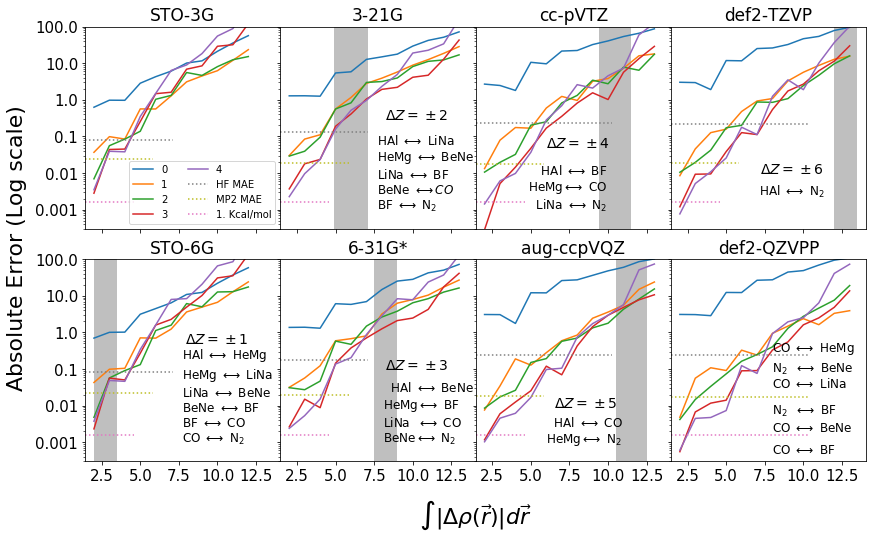

In [23]:
fig= plt.figure(figsize=(14,8))
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.axes().set_ylabel("Absolute Error (Log scale) ",fontsize=22,labelpad=35)
plt.axes().set_xlabel(r'$ \int |\Delta \rho (\vec{r})| d \vec{r} $' , fontsize=22,labelpad=20)
plt.axes().set_frame_on(False)

axs = fig.subplots(2, 4,sharex=True, sharey=True)

plot(axs[0,0],dt_sto3g,"STO-3G")
plot(axs[1,0],dt_sto6g,"STO-6G")
plot(axs[0,1],dt_321g,"3-21G")
plot(axs[1,1],dt_631g,"6-31G*")
plot(axs[0,2],dt_ccpvtz,"cc-pVTZ")
plot(axs[1,2],dt_aug,"aug-ccpVQZ")
plot(axs[0,3],dt_tzvp,"def2-TZVP") 
plot(axs[1,3],dt_qzvpp,"def2-QZVPP")
plt.subplots_adjust(hspace=0.15,wspace=0)
axs[0,0].legend(loc=4,ncol=2,fontsize=10)



axs[1,0].axvspan(2.0, 3.5, color='grey', alpha=0.5, lw=0)
axs[1,0].text(7.9,.5,"$ \Delta Z = \pm 1 $",fontsize=14)
z1='\n'.join((r'HAl $ \longleftrightarrow $ HeMg ',r'HeMg $ \longleftrightarrow $ LiNa ',r'LiNa $ \longleftrightarrow$ BeNe  '\
             ,r'BeNe $ \longleftrightarrow $ BF ',r'BF $ \longleftrightarrow $ CO ',r'CO $ \longleftrightarrow$ N$_2$' ))
axs[1,0].text(7.7,0.001,z1,fontsize=12)

axs[0,1].axvspan(4.9, 7.1, color='grey', alpha=0.5, lw=0)
axs[0,1].text(8.2,0.3,"$ \Delta Z = \pm 2 $",fontsize=14)
z2='\n'.join((r'HAl $ \longleftrightarrow $ LiNa ',r'HeMg $ \longleftrightarrow $ BeNe ',r'LiNa $ \longleftrightarrow $ BF',\
              r'BeNe $ \longleftrightarrow CO$'\
             ,r'BF $ \longleftrightarrow $ N$_2$  '))
axs[0,1].text(7.7,0.001,z2,fontsize=12)

axs[1,1].axvspan(7.5,9., color='grey', alpha=0.5, lw=0)
axs[1,1].text(8.2,0.1,"$ \Delta Z = \pm 3 $",fontsize=14)
z3='\n'.join((r'  HAl $ \longleftrightarrow $ BeNe',r'HeMg$\longleftrightarrow $ BF','LiNa  $ \longleftrightarrow $ CO',\
              r'BeNe$\longleftrightarrow$ N$_2$  '))
axs[1,1].text(8.1,0.001,z3,multialignment='left',fontsize=12)

axs[0,2].axvspan(9.4,11.5, color='grey', alpha=0.5, lw=0)
axs[0,2].text(6.,0.05,"$ \Delta Z = \pm 4 $",fontsize=14)
z4='\n'.join((r' HAl $ \longleftrightarrow $ BF',r'HeMg$ \longleftrightarrow $ CO',' LiNa $ \longleftrightarrow$ N$_2$'))
axs[0,2].text(4.8,0.001,z4,multialignment='right',fontsize=12)

axs[1,2].axvspan(10.5,12.5, color='grey', alpha=0.5, lw=0)
axs[1,2].text(6.5,0.009,"$ \Delta Z = \pm 5 $",fontsize=14)
z5='\n'.join((r'  HAl $ \longleftrightarrow $ CO',r'HeMg$ \longleftrightarrow $ N$_2$'))
axs[1,2].text(6.,0.001,z5,fontsize=12)

axs[0,3].axvspan(12,13.5, color='grey', alpha=0.5, lw=0)
axs[0,3].text(7.2,0.01,"$ \Delta Z = \pm 6 $",fontsize=14)
axs[0,3].text(7.1,0.0025,r'HAl $ \longleftrightarrow $ N$_2$ ',fontsize=12)


axs[1,3].text(8.,5.e-4,r'CO $ \longleftrightarrow$ BF ',fontsize=12)

axs[1,3].text(8.,2.e-3,r'CO $\longleftrightarrow$ BeNe ',fontsize=12)
axs[1,3].text(8.,6.e-3,r'N$_2$  $ \longleftrightarrow$ BF ',fontsize=12)

axs[1,3].text(8.,.08,r'N$_2$  $ \longleftrightarrow$ BeNe ',fontsize=12)
axs[1,3].text(8.,.032,r'CO $ \longleftrightarrow$ LiNa ',fontsize=12)

axs[1,3].text(8.,.3,r'CO $ \longleftrightarrow$ HeMg ',fontsize=12)

for ax in axs.flatten():
    ax.set_yticklabels(ax.get_yticks(),fontsize=15)
    ax.set_xticklabels(ax.get_xticks(),fontsize=15)
plt.savefig("median_error.pdf")